In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from utils import translate, pairwise_kernels

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import pairwise_distances

In [122]:
# constants
N_POINTS_ARR = [100, 200, 400, 800]
N_NEIGHBORS = 15
N_RUNS = 5

EPS_MEAN = 0
EPS_STD_DEV = 0.05

In [123]:
# creating true data
x = np.linspace(-0.7, 0.7, 25)
y = np.linspace(-0.7, 0.7, 25)

xx, yy = np.meshgrid(y, x)
##zz = 0.3 * np.sin(2 * xx) + 0.1 * np.cos(3.5 * xx) + 0.25 * np.exp(-yy) - 0.5

zz = np.sqrt(1.0 - xx**2 - yy**2)

In [124]:
# creating empirical data
x_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
y_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
z_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        
        x = np.random.uniform(-0.7, 0.7, N_POINTS)
        y = np.random.uniform(-0.7, 0.7, N_POINTS)
        #z = 0.3 * np.sin(2 * y) + 0.1 * np.cos(3.5 * y) + 0.25 * np.exp(-x) - 0.5
        z = np.sqrt(1 - x ** 2 - y ** 2)

        x_arr[i][j] = x
        y_arr[i][j] = y
        z_arr[i][j] = z

In [125]:
# nonparametic regression
T_x = np.linspace(-1, 1, 100)
T_y = np.linspace(-1, 1, 100)

T_xx, T_yy = np.meshgrid(T_x, T_y)

T = np.dstack((T_xx, T_yy)).reshape(-1, 2)

X_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
z_hat_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):

        X = np.dstack((y_arr[i][j], x_arr[i][j])).reshape(N_POINTS, -1)

        nonparametric_regression = KNeighborsRegressor(n_neighbors=N_NEIGHBORS)
        z_hat = nonparametric_regression.fit(X, z_arr[i][j]).predict(T)

        X_arr[i][j] = X
        z_hat_arr[i][j] = z_hat

In [77]:
# plot styling
line_marker_blue = dict(color='#0066FF', width=1)
line_marker_green = dict(color='#00CC66', width=1)
line_marker_red  = dict(color='#CC3300', width=2)
line_marker_grey  = dict(color='#333333', width=2)
marker = dict(size=2, color='#0066FF')

In [100]:
# empirical data, true and regression plot
lines = []

lines.append(go.Scatter3d(x=y_arr[0][0], y=x_arr[0][0], z=z_arr[0][0], marker=marker, mode="markers"))

for i, j, k in zip(xx, yy, zz):
    lines.append(go.Scatter3d(x=i, y=j, z=k, line=line_marker_blue, mode="lines", opacity=0.5, hoverinfo="skip"))

scene = dict(
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-0.1),
        eye=dict(x=0.65, y=0.8, z=0.9)
    )
)

layout = go.Layout(
    #title='Data points sampled from hemisphere',
    showlegend=False,
    scene=scene
)

fig = go.Figure(data=lines, layout=layout, )
py.iplot(fig)

In [126]:
# extracting neighborhoods
neigborhoods_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
neigborhoods_ids_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
points_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        points = np.hstack((X_arr[i][j], z_arr[i][j].reshape(N_POINTS, -1)))
        nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS).fit(points)
        distances, indices = nbrs.kneighbors(points)
        neigborhoods = points[indices]
        neigborhoods_ids = indices
        #neigborhoods[0], neigborhoods_ids[0],
        #neigborhoods.shape

        points_arr[i][j] = points
        neigborhoods_arr[i][j] = neigborhoods
        neigborhoods_ids_arr[i][j] = neigborhoods_ids

In [127]:
neigborhoods_arr[0][0].shape

(100, 15, 3)

In [128]:
# create Q(X_i) matrix
D = 3 # dimensionality of ambient space
d = 2 # dimensionality of embedding space

Q_X_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        Q_X = np.zeros((N_POINTS, D, d)) # Q(X_i), N_POINTS x d x D
        Q_X_arr[i][j] = Q_X

In [129]:
Q_X_arr[0][0].shape

(100, 3, 2)

In [130]:
# estimating tangent spaces
for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        for k, _ in enumerate(neigborhoods_arr[i][j]):

            neigborhood_local = translate(neigborhoods_arr[i][j][k], neigborhoods_arr[i][j][k][0])
            U, S, V = np.linalg.svd(neigborhood_local.T.dot(neigborhood_local))

            Q_X_arr[i][j][k] = V[:d].T # take first d eigenvectors

In [131]:
Q_X_arr[0][0][0]

array([[-0.14057382, -0.8904425 ],
       [ 0.97791905, -0.05659307],
       [-0.15463937,  0.45156326]])

In [121]:
# tangent vectors plot
tangent_plot = []

for i, _ in enumerate(neigborhoods_arr[0][0]):
    if (i > 500): break # remove!
    
    for e, eigenvector in enumerate(Q_X_arr[0][0][i].T):
        
        tangent_vector = [[points_arr[0][0][i][0], points_arr[0][0][i][0] + eigenvector[0]],
                          [points_arr[0][0][i][1], points_arr[0][0][i][1] + eigenvector[1]],
                          [points_arr[0][0][i][2], points_arr[0][0][i][2] + eigenvector[2]]]
        
        if (e==0):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_red, mode="lines", opacity=0.5, hoverinfo="skip"))
            
        if (e==1):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_grey, mode="lines", opacity=0.5, hoverinfo="skip"))

        #print(tangent_vector)
        #print("\r")
            
lines.append(go.Scatter3d(x=y_arr[0][0], y=x_arr[0][0], z=z_arr[0][0], marker=marker, mode="markers"))

for i, j, k in zip(xx, yy, zz):
    tangent_plot.append(go.Scatter3d(x=i, y=j, z=k, line=line_marker_blue, mode="lines", opacity=0.5, hoverinfo="skip"))

scene = dict(
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-0.1),
        eye=dict(x=0.65, y=0.8, z=0.9)
    )
)
            
layout = go.Layout(
    title='PCA-estimated tangent spaces',
    showlegend=False,
    scene=scene
)
fig = go.Figure(data=tangent_plot, layout=layout)
py.iplot(fig)

In [112]:
H_X_arr = np.copy(Q_X_arr)

3 steps:

1. Nadaraya-Watson nonparametric regression
2. Projection to original tangent plane
3. Changing vector length

$$H_i^{(k+1)} = C \cdot Q_iQ_i^T \cdot \frac{\sum_j K(X_i, X_j) \cdot H_j^{(k)}}{\sum_j K(X_i, X_j)}$$

$$H_i^{(k+1)} = P(X_i) \cdot \frac{\sum_j K(X_i, X_j) \cdot H_j^{(k)}}{\sum_j K(X_i, X_j)}$$

$$\sum_{i,j} K(X_i, X_j) \cdot \| H(X_i) - H(X_j) \|_F^2 \rightarrow \min_{H_i}$$

In [132]:
# iterative update
n_iter = 100

deltas_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

# initialize I_D, H_X
I_D = np.eye(D)
I_d = np.eye(d)
I_d_diag = np.vstack([I_d, np.array([0., 0.])])

#print(H_X_arr[0][0][0], np.linalg.norm(H_X_arr[0][0][0]))

H_X_arr = np.copy(Q_X_arr)
H_X_arr_next = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for n, N_POINTS in enumerate(N_POINTS_ARR):
    for m in range(N_RUNS):
        
        print("N={}, M={}".format(n, m))
        
        for k in range(n_iter): # run k iterations

            H_X_arr_next[n][m] = np.zeros((N_POINTS, D, d))

            for i in range(N_POINTS): # update N_POINTS

                neighborhood = neigborhoods_arr[n][m][i]
                j = neigborhoods_ids_arr[n][m][i][1:]

                # kernel
                K = pairwise_kernels(neighborhood)[0][1:]

                # projection to original tangent plane
                P_i = Q_X_arr[n][m][i].dot(Q_X_arr[n][m][i].T)

                H_i = (K[:,None,None] * H_X_arr[n][m][j]).sum(axis=0) / K.sum()
                H_P_ij = P_i.dot(H_i)

                U, S, V = np.linalg.svd(H_P_ij)
                
                #print(U.dot(I_d_diag).dot(V))

                H_X_arr_next[n][m][i] = U.dot(I_d_diag).dot(V)

            H_X_arr[n][m] = H_X_arr_next[n][m]

            # functional
            delta = 0
            for i in range(N_POINTS):
                #if (i > 1): break

                neighborhood = neigborhoods_arr[n][m][i]
                j = neigborhoods_ids_arr[n][m][i][1:]

                # kernel
                K = pairwise_kernels(neighborhood)[0][1:]

                H_D = H_X_arr[n][m][i] - H_X_arr[n][m][j]

                delta += (K * np.array(map(np.linalg.norm, H_D))).sum()

            #deltas.append(delta)
            
            deltas_arr[n][m].append(delta)

N=0, M=0
N=0, M=1
N=0, M=2
N=0, M=3
N=0, M=4
N=1, M=0
N=1, M=1
N=1, M=2
N=1, M=3
N=1, M=4
N=2, M=0
N=2, M=1
N=2, M=2
N=2, M=3
N=2, M=4
N=3, M=0
N=3, M=1
N=3, M=2
N=3, M=3
N=3, M=4


In [114]:
#deltas_arr

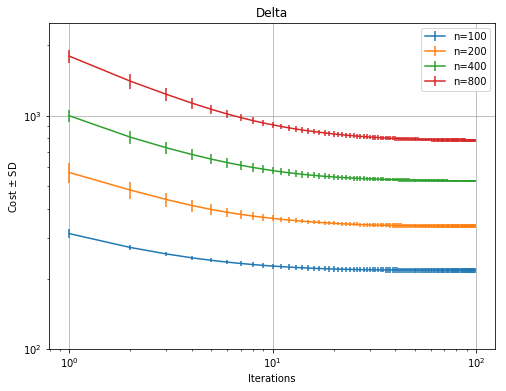

In [136]:
captions = []
plt.figure(figsize=(8, 6))

for i, N_POINTS in enumerate(N_POINTS_ARR):
    deltas_np_arr = np.array(deltas_arr[i])
    mean = list(deltas_np_arr.mean(axis=0))
    std = list(deltas_np_arr.std(axis=0))
    x = range(len(std))
    #mean, std
    
    cap = plt.errorbar(x, mean, yerr=std, label=("n=" + str(N_POINTS)))
    captions.append(cap)

#plt.errorbar(x, mean, yerr=std)
#plt.xscale('log')
#plt.yscale('log')

# visualize transitions
plt.legend(handles=captions)
plt.title('Delta', fontdict={'size': 12 })
plt.ylabel('Cost $\pm$ SD')
plt.xlabel('Iterations')
plt.xscale('log')
plt.yscale('log')
plt.ylim([100, 2500])
plt.grid()
plt.show()

In [115]:
deltas_np_arr = np.array(deltas_arr[0])
mean = list(deltas_np_arr.mean(axis=0))
std = list(deltas_np_arr.std(axis=0))
x = range(len(std))
mean, std

([865.8283201467757,
  553.11112775055312,
  463.96163418686268,
  424.58437485654161,
  401.49528689193062,
  387.36070638195804,
  378.21629236568344,
  372.07518747736395,
  367.77661344445966,
  364.63627754411272,
  362.2405081585012,
  360.33671134845309,
  358.76877318348818,
  357.43898532473975,
  356.28517649273107,
  355.26694998858392,
  354.35734529638461,
  353.53776926081662,
  352.79490226363782,
  352.11880265950759,
  351.50173953064598,
  350.93746916084888,
  350.42078245277258,
  349.94721828963458,
  349.51287892760593,
  349.11430844684122,
  348.74841044436999,
  348.41239037467938,
  348.10371356550468,
  347.82007337002375,
  347.55936601875544,
  347.3196700246599,
  347.09922878914472,
  346.89643554711608,
  346.70982009323603,
  346.53803692080413,
  346.37985452316525,
  346.23414568223723,
  346.09987861626547,
  345.97610888954108,
  345.86197200690424,
  345.75667662933859,
  345.65949835630795,
  345.56977402722077,
  345.48689649945675,
  345.4103098

In [116]:
deltas_np_arr = np.array(deltas_arr)
y = list(deltas_np_arr[:,:,-1].flatten())
x = N_POINTS_ARR
x, y

([200], [344.41715962427344])

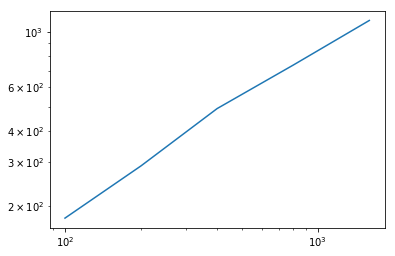

In [302]:
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [118]:
#plt.errorbar(x, mean, yerr=std)
#plt.xscale('log')
#plt.yscale('log')
#plt.show()

In [120]:
# tangent vectors plot
tangent_plot = []

for i, _ in enumerate(neigborhoods_arr[0][0]):
    if (i > 500): break # remove!
    
    for e, eigenvector in enumerate(H_X_arr[0][0][i].T):
        
        tangent_vector = [[points_arr[0][0][i][0], points_arr[0][0][i][0] + eigenvector[0]],
                          [points_arr[0][0][i][1], points_arr[0][0][i][1] + eigenvector[1]],
                          [points_arr[0][0][i][2], points_arr[0][0][i][2] + eigenvector[2]]]

        if (e==0):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_red, mode="lines", opacity=0.5, hoverinfo="skip"))
        if (e==1):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_grey, mode="lines", opacity=0.5, hoverinfo="skip"))

        #print(tangent_vector)
        #print("\r")
            
tangent_plot.append(go.Scatter3d(x=y_arr[0][0], y=x_arr[0][0], z=z_arr[0][0], marker=marker, mode="markers"))

for i, j, k in zip(xx, yy, zz):
    tangent_plot.append(go.Scatter3d(x=i, y=j, z=k, line=line_marker_blue, mode="lines", opacity=0.5, hoverinfo="skip"))
            
scene = dict(
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-0.1),
        eye=dict(x=0.65, y=0.8, z=0.9)
    )
)
            
layout = go.Layout(
    title='Aligned tangent spaces',
    showlegend=False,
    scene=scene
)
fig = go.Figure(data=tangent_plot, layout=layout)
py.iplot(fig)